In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf

import xgboost as xgb
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

import datetime
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_1.csv', '20190103_2.csv', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', 'accurate.xlsx', 'comments.txt', 'dot_result.csv', 'dot_result_new.csv', 'feature_importance.png', 'rmse1.csv', 'test.csv', 'test_predict.png']


In [2]:
rcParams['figure.figsize'] = 16,4

In [3]:
dot_data_1 = pd.read_excel(path + '20190103_点部取货量_1.xlsx', parse_dates=[1])
dot_data_2 = pd.read_excel(path + '20190103_点部取货量_2.xlsx', parse_dates = [1])

In [4]:
dot_data = pd.concat([dot_data_1,dot_data_2],ignore_index = True)
data = dot_data.copy()
data.head()

,dot,order_date,order_num,num,jifei_weight,shiji_weight,longitude,latitude
0,13825092291,2017-05-23,1,1,1.0,1.0,NaN,NaN
1,15102680258,2017-06-06,1,1,1.0,1.0,NaN,NaN
2,ERP客户系统组,2017-06-09,1,1,3.0,3.0,NaN,NaN
3,IT采购组,2017-04-13,8,8,8.0,8.0,NaN,NaN
4,IT采购组,2017-05-03,4,5,10.0,10.0,NaN,NaN


In [5]:
data = data.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)

In [6]:
data_ts = data.copy()
data_ts.index = pd.to_datetime(data['order_date'])
data_ts.head()

,dot,order_date,order_num
order_date,,,
2017-05-23,13825092291,2017-05-23,1
2017-06-06,15102680258,2017-06-06,1
2017-06-09,ERP客户系统组,2017-06-09,1
2017-04-13,IT采购组,2017-04-13,8
2017-05-03,IT采购组,2017-05-03,4


In [7]:
data_ts.sort_index(ascending = True, inplace = True)
tmp = data_ts['2017-12':]
tmp.head()

,dot,order_date,order_num
order_date,,,
2017-12-01,坂田上雪点部,2017-12-01,313
2017-12-01,嘉定城区点部,2017-12-01,20
2017-12-01,荔湾芳村二级装卸组,2017-12-01,1
2017-12-01,无锡旺庄点部,2017-12-01,58
2017-12-01,宝安机场分拨一区包车组,2017-12-01,2


In [8]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 390, ['dot']]
len(useful_dot_name)

338

In [9]:
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(useful_dot_name['dot']):
    one_dot = data.loc[data['dot'] == dot]
    one_dot = one_dot.loc[one_dot["order_date"] >= pd.to_datetime('2017-12-01')]
    num_median = np.median(one_dot['order_num'])
    ts = pd.date_range('2017-12-01', '2018-12-31')
    df_ts = pd.DataFrame(ts, columns = ['order_date'])
    df_ts['dot'] = dot
    df_ts['dot_id'] = i + 1
    merge_res = pd.merge(df_ts, one_dot, how= 'left')
#     merge_res = merge_res.loc[merge_res["order_date"] >= pd.to_datetime('2017-12-01')]
    merge_res['order_num'].fillna(num_median, inplace = True)
    if len(merge_res) >= 390:
        dot_preprocessing = pd.concat([dot_preprocessing, merge_res], axis = 0,ignore_index = True)

In [10]:
dot_prep = dot_preprocessing[['dot', 'dot_id', 'order_date', 'order_num']]
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133848 entries, 0 to 133847
Data columns (total 4 columns):
dot           133848 non-null object
dot_id        133848 non-null int64
order_date    133848 non-null datetime64[ns]
order_num     133848 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.1+ MB


## 拆分

In [11]:
dot_train = dot_prep[: -(30 * 338)]
dot_test = dot_prep[-(30 * 338) :]   # 每个点部留一个月数据做测试

## 创建特征

In [12]:
def create_feature(data):
    # 时间
    dot_prep_1 = data.copy()
    
    dot_prep_1['year'] = dot_prep_1.order_date.dt.year
    dot_prep_1['month'] = dot_prep_1.order_date.dt.month
    dot_prep_1['day'] = dot_prep_1.order_date.dt.day
    dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
    dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
    dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
    weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep['order_date'].unique())/7), freq = 'W-SUN')
    dot_prep_1['weekofsun'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
#     dot_prep_1['season'] = 1
#     dot_prep_1.loc[dot_prep_1['month'].isin([1,2,3]), ['season']] = 1
#     dot_prep_1.loc[dot_prep_1['month'].isin([4,5,6]), ['season']] = 2
#     dot_prep_1.loc[dot_prep_1['month'].isin([7,8,9]), ['season']] = 3
#     dot_prep_1.loc[dot_prep_1['month'].isin([10,11,12]), ['season']] = 4
    
    dot_prep_1['holidays'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    
    # lagging
    dot_prep_ts = data.copy()
    dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
    
    dot_prep_2 = pd.DataFrame()
    for dot in useful_dot_name['dot']:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
        lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
        lagging['dot'] = dot
        lagging['order_date'] = dot_ts.index
        lagging.dropna(axis = 0, inplace = True)
        dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
    dot_prep_2.reset_index(drop = True, inplace = True)
    
    # rolling
    dot_prep_3 = pd.DataFrame()
    for dot in useful_dot_name['dot']:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        rolling = pd.concat([dot_ts.rolling(window = 3).mean(), dot_ts.rolling(window = 5).mean(), dot_ts.rolling(window = 7).mean(), dot_ts.rolling(window = 8).mean()], axis = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7', 'rolling8']
        rolling['dot'] = dot
        rolling['order_date'] = dot_ts.index
        rolling.dropna(axis = 0, inplace = True)
        dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
    dot_prep_3.reset_index(drop = True, inplace = True)
    
    # merge
    dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
    dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
    dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
#     dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)
    
    return dot_prep_result

In [14]:
dot_prep_train = create_feature(dot_train)
dot_prep_test = create_feature(dot_test)

In [162]:
# one_hot = pd.get_dummies(dot_prep_test['dot'])

In [164]:
# dot_prep_train = pd.merge(dot_prep_train, one_hot, left_index = True, right_index = True)
# dot_prep_test = pd.merge(dot_prep_test, one_hot, left_index = True, right_index = True)

In [174]:
# dot_prep_test.head()

In [145]:
# 统计特征
# dot_prep_sta = dot_prep_train.copy()
# dot_prep_dayofweek = dot_prep_sta.groupby(['dot_id', 'dayofweek'])['order_num'].agg([('week_mean', np.mean), ('week_median', np.median), ('week_min', np.min), ('week_max', np.max), ('week_std', np.std)]).reset_index()
# dot_prep_day = dot_prep_sta.groupby(['dot_id', 'day'])['order_num'].agg([('day_mean', np.mean), ('day_median', np.median), ('day_min', np.min), ('day_max', np.max), ('day_std', np.std)]).reset_index()
# dot_prep_tmp = pd.merge(dot_prep_4, dot_prep_dayofweek, on = ['dot_id', 'dayofweek'], how = 'left')
# dot_prep_4 = pd.merge(dot_prep_tmp, dot_prep_day, on = ['dot_id', 'day'], how = 'left')

In [15]:
dot_prep_train.columns

Index(['dot', 'dot_id', 'order_date', 'order_num', 'year', 'month', 'day',
       'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays',
       'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6',
       'lagging7', 'rolling3', 'rolling5', 'rolling7', 'rolling8'],
      dtype='object')

In [16]:
dot_xtrain = dot_prep_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_prep_train['order_num']
dot_xtest = dot_prep_test.drop(['order_num'], axis = 1)
dot_ytest = dot_prep_test['order_num']

In [17]:
dot_prep_train.drop(['dot'], axis = 1)[dot_xtrain['dot_id']==1].tail(10)

,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,...,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling5,rolling7,rolling8
118031,1,2018-11-22,78.0,2018,11,22,3,326,47,0,...,74.0,70.0,111.0,213.0,63.0,63.0,76.333333,82.0,98.000000,93.625
118618,1,2018-11-23,53.0,2018,11,23,4,327,47,0,...,77.0,74.0,70.0,111.0,213.0,63.0,69.333333,70.4,96.571429,92.375
118781,1,2018-11-24,79.0,2018,11,24,5,328,47,0,...,78.0,77.0,74.0,70.0,111.0,213.0,70.000000,72.2,77.428571,94.375
119092,1,2018-11-25,72.0,2018,11,25,6,329,47,1,...,53.0,78.0,77.0,74.0,70.0,111.0,68.000000,71.8,71.857143,76.750
119632,1,2018-11-26,80.0,2018,11,26,0,330,48,0,...,79.0,53.0,78.0,77.0,74.0,70.0,77.000000,72.4,73.285714,72.875
119828,1,2018-11-27,78.0,2018,11,27,1,331,48,0,...,72.0,79.0,53.0,78.0,77.0,74.0,76.666667,72.4,73.857143,73.875
120092,1,2018-11-28,71.0,2018,11,28,2,332,48,0,...,80.0,72.0,79.0,53.0,78.0,77.0,76.333333,76.0,73.000000,73.500
120384,1,2018-11-29,85.0,2018,11,29,3,333,48,0,...,78.0,80.0,72.0,79.0,53.0,78.0,78.000000,77.2,74.000000,74.500
120971,1,2018-11-30,94.0,2018,11,30,4,334,48,0,...,71.0,78.0,80.0,72.0,79.0,53.0,83.333333,81.6,79.857143,76.500
121127,1,2018-12-01,58.0,2018,12,1,5,335,48,0,...,85.0,71.0,78.0,80.0,72.0,79.0,79.000000,77.2,76.857143,77.125


## 评估方法

In [18]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

In [19]:
def xgboost_model(x_train, y_train):
    params = {
        "learning_rate": 0.01,                   # [0,1]， 默认0.3
        "n_estimators": 3300,
        "max_depth": 5,                         # [0,∞]， 默认6
        "min_child_weight": 3,                  # [0,∞]， 默认1
        "gamma": 0.5,                             # [0,∞]， 默认0
        "subsample": 0.9,                       # (0,1]， 默认1
        "colsample_bytree": 0.8,                # (0,1]， 默认1
        "silent": 1,                            # 默认0，输出信息
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    print("train_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(x_train.drop(['dot', 'order_date'], axis = 1), y_train)
    print("train_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")
    
    return gbm

def xgb_predict(gbm, x_test, y_test, path):
    # 验证
    print("predict_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    print("predict_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : y_test, 'y_pre' : y_pre})
    result['RMSE'] = RMSE(y_test, y_pre)
    result['MAE'] = MAE(y_test, y_pre)
    print("MAE : ", MAE(y_test, y_pre), " RMSE : ", RMSE(y_test, y_pre))
    
    result.to_csv(path + "dot_result.csv", encoding = 'GBK', index = False)
    return result

In [20]:
gbm = xgboost_model(dot_xtrain, dot_ytrain)

train_start :  2019-02-14 10:05:00
train_end :  2019-02-14 10:12:07
dot_id 	 0.0067723785
year 	 0.00022901762
month 	 0.0065978887
day 	 0.01688187
dayofweek 	 0.0443858
dayofyear 	 0.014188187
weekofyear 	 0.0020175362
weekofsun 	 0.0035116035
holidays 	 0.011461787
lagging1 	 0.20957294
lagging2 	 0.18685657
lagging3 	 0.037297156
lagging4 	 0.03691546
lagging5 	 0.020077212
lagging6 	 0.018190542
lagging7 	 0.046970423
rolling3 	 0.24652112
rolling5 	 0.047864683
rolling7 	 0.018724917
rolling8 	 0.02496292


In [21]:
result = xgb_predict(gbm, dot_xtest, dot_ytest, path)

predict_start :  2019-02-14 10:12:09
predict_end :  2019-02-14 10:12:10
MAE :  5.2546027762926055  RMSE :  21.891356516658192


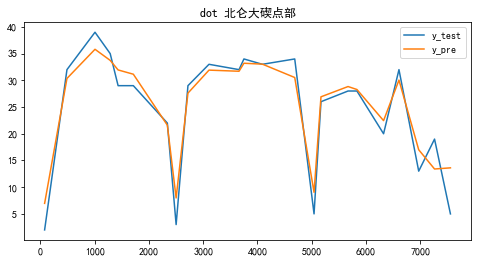

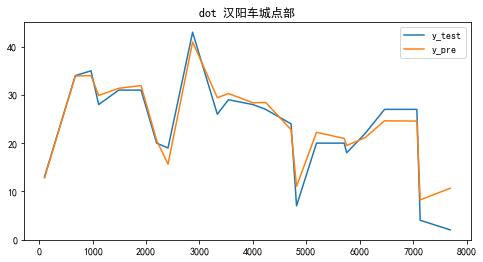

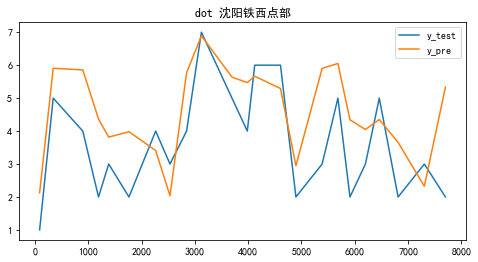

In [22]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_test','y_pre']
L = np.random.randint( low = 0, high = 337, size = 3 )
for i in L:
    s1 = pd.DataFrame(result[result['dot'] == result['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(result['dot'].unique()[i]), figsize = (8,4))

In [ ]:
def RollData(data,windowsize=None,rollcol="jiangshu"):
    dot=data["dot"].unique().tolist()
    DF=pd.DataFrame() 
    for i in dot:
        df=data[data["dot"]==i]
        df2=pd.DataFrame(index=df.index+pd.DateOffset(days=1))
        df2['roll']= df[rollcol].values
        for j in windowsize:
            if j>1:
                df['roll_mean_'+str(j)] = pd.Series(df2['roll'].rolling(j).mean())
            df1=pd.DataFrame(index=df.index+pd.DateOffset(days=j))
            df1['roll_' + str(j)]= df[rollcol].values
            df=pd.merge(df,df1,how="left",right_index=True,left_index=True)
        DF=pd.concat([DF,df])
    return DF

In [ ]:
gbm = xgb.XGBRegressor(max_depth=8,
                       learning_rate=0.01,
                       n_estimators=1000,
                       silent=True,
                       objective=mape_object,
                       #objective='reg:linear',
                       nthread=-1,
                       gamma=0,
                       min_child_weight=6,
                       max_delta_step=0,
                       subsample=0.9,
                       colsample_bytree=0.8,
                       colsample_bylevel=1,
                       reg_alpha=1e0,
                       reg_lambda=0,
                       scale_pos_weight=1,
                       seed=9,
                       missing=None)

gbm.fit(train.values, train_label.values, eval_metric=mape_ln, 
        verbose=True, eval_set=[(test.values, test_label.values)],
        early_stopping_rounds=10)

In [25]:
a = pd.DataFrame([1,2,3,4,5,6,7,8,9, None])
a

,0
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0
5,6.0
6,7.0
7,8.0
8,9.0
9,NaN


In [27]:
pd.concat([a.ewm(span = 3).mean(), a.ewm(span = 7).mean()], axis = 1)

,0,0
0,1.000000,1.000000
1,1.666667,1.571429
2,2.428571,2.189189
3,3.266667,2.851429
4,4.161290,3.555698
5,5.095238,4.299079
6,6.055118,5.078326
7,7.031373,5.890004
8,8.017613,6.730621
9,8.017613,6.730621


In [ ]:
pd.concat([a.rolling(window=3, min_periods = 2).mean(), a.rolling(window=5, min_periods = 4).mean(), a.rolling(window=6).mean()], axis = 1)